# Predição de mortalidade em internações por pneumonias bacterianas sensíveis à Atenção Primária no Brasil, 2017-2021

## Análise preditiva

### 1. Importando pacotes de análise

In [14]:
# IMPORTANDO PACOTES 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd  
import pylab as pl
import chart_studio.plotly as py
import plotly.graph_objs as gp 
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split

### 2. Importando dados

In [2]:
#IMPOTANDO DADOS
sih_fn = pd.read_csv("sih_pneumonia_1721_trat.csv", index_col= 'N_AIH')
sih_fn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658719 entries, 1217100049066 to 1721101761060
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDADE       658719 non-null  float64
 1   SEXO        658719 non-null  int64  
 2   MORTE       658719 non-null  int64  
 3   DIAS_PERM   658719 non-null  int64  
 4   DIAG_PRINC  658719 non-null  int64  
 5   MARCA_UTI   658719 non-null  int64  
 6   UTI_MES_TO  658719 non-null  int64  
 7   REGIAO      658719 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 45.2 MB


### 3. Definindo teste e treino

In [3]:
#SEPARANDO OS DADOS
train, test = train_test_split(sih_fn, train_size=0.70, random_state=42)

### 4. Treinando o modelo de predição

#### 4.1 Estimando o modelo por Regressão Logística

In [4]:
#ESTIMANDO O MODELO
log_reg = smf.logit("MORTE ~ IDADE + SEXO + DIAS_PERM + DIAG_PRINC + MARCA_UTI + UTI_MES_TO + REGIAO", data = train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.257790
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  MORTE   No. Observations:               461103
Model:                          Logit   Df Residuals:                   461095
Method:                           MLE   Df Model:                            7
Date:                Mon, 26 Sep 2022   Pseudo R-squ.:                  0.1776
Time:                        14:50:38   Log-Likelihood:            -1.1887e+05
converged:                       True   LL-Null:                   -1.4453e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8624      0.022   -219.278      0.000      -4.906      -4.819
IDADE          0.0403      0.

#### 4.2 Avaliando o Modelo de Regressão Logística

In [5]:
#ANALISANDO RESULTADOS DO MODELO
test_featues = test.drop("MORTE", axis= 1)

ytest = test["MORTE"]

ypred = log_reg.predict(test_featues)

In [6]:
#TABELA DE CONTINGÊNCIA PARA OS RESULTADOS - COM THRESHOLD = 0.5
ypred2 = np.where(ypred >= 0.5, 1, 0)

pd.crosstab(ytest, ypred2, margins= True)

col_0,0,1,All
MORTE,,,
0,177839,1079,178918
1,17564,1134,18698
All,195403,2213,197616


In [7]:
#INCLUINDO DADOS DE RESULTADO DA PREDIÇÃO NO DATAFRAME DE TESTE
test["PRED"] = ypred

In [8]:
#CALCULANDO MÉTRICAS PARA A CURVA ROC
fpr, tpr, thresholds = roc_curve(test["MORTE"], test["PRED"])
roc_auc = auc(fpr, tpr)

print("Área abaixo da curva ROC: %f" % roc_auc)

Área abaixo da curva ROC: 0.801614


Text(0, 0.5, 'Taxa de Verdadeiros positivos')

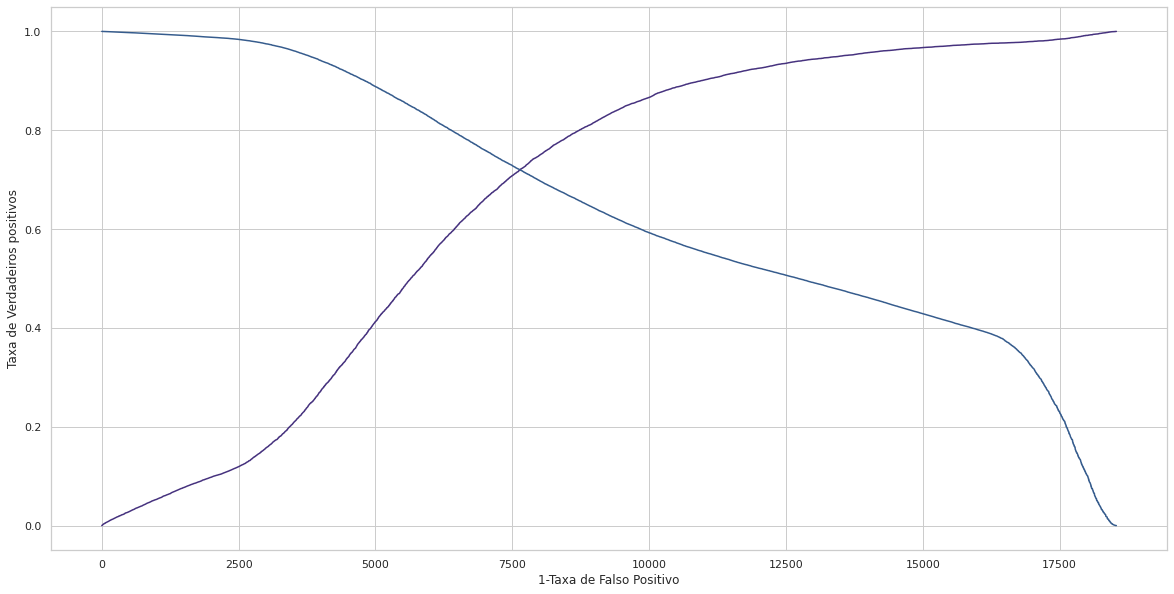

In [17]:
#PLOTANDO CURVA ROC
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

sns.set(rc={'figure.figsize':(20, 10)})
sns.set_theme(style="whitegrid", palette="viridis")

pl.plot(roc['tpr'])
pl.plot(roc['1-fpr'])
pl.xlabel('1-Taxa de Falso Positivo')
pl.ylabel('Taxa de Verdadeiros positivos')

#### 4.3 Escolhendo o melhor *threshold* de classificação para o modelo

In [10]:
#DEFININDO MELHOR CUTOFF PARA O MODELO
def optimal_cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


threshold = optimal_cutoff(test["MORTE"], test["PRED"])
print(threshold)

[0.12679588195891706]


In [11]:
#INCLUINDO RESULTADOS NO DATAFRAME
test["PRED_CLASS"] = np.where(test["PRED"] >= 0.12679588195891706, 1, 0)

In [12]:
#MATRIZ DE CONFUSÃO
pd.crosstab(test["MORTE"], test["PRED_CLASS"], margins=True)

PRED_CLASS,0,1,All
MORTE,,,
0,128794,50124,178918
1,5241,13457,18698
All,134035,63581,197616


In [16]:
#CALCULANDO MÉTRICAS DO MODELO
print(classification_report(test["MORTE"], test["PRED_CLASS"]))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    178918
           1       0.21      0.72      0.33     18698

    accuracy                           0.72    197616
   macro avg       0.59      0.72      0.58    197616
weighted avg       0.89      0.72      0.78    197616

